In [1]:
#import important modules
import pymongo as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from pymongo import MongoClient
import json
import pickle
import re
import pprint
import datetime
import statistics as st

In [2]:
#load the file with conversations
with open('editeddata/conversations.json', 'r') as convo_json:
    convos = json.load(convo_json)

In [3]:
#connect to mongodb
client = MongoClient('localhost', 27017)
mydb = client.tweets
col = mydb['_tweets']

In [4]:
airlines = {'KLM':56377143, 
            'AirFrance': 106062176, 
            'British_Airways': 18332190, 
            'AmericanAir': 22536055, 
           'Lufthansa': 124476322, 
           'AirBerlin': 26223583, 
           'AirBerlinAssist': 2182373406, 
           'easyJet': 38676903, 
           'RyanAir': 1542862735, 
           'SingaporeAir': 253340062, 
           'Qantas': 218730857, 
           'EtihadAirways': 45621423, 
           'VirginAtlantic': 20626359}

In [31]:
#previously pickled dictionary
air_count = pickle.load(open("save.p", "rb"))

Get:
- the ratio of replied to all tweets for every airline
- number of received tweets
- ratio of received to replied tweets

In [48]:
for name in airlines:
    if len(air_count[name]['ids']) != 0: #checking so that we don't divide by zero later
        conv_tweets = len(air_count[name]['ids']) - len(list(col.find({'user.id': airlines[name], 'in_reply_to_user_id':'none'})))
        a = len(list(col.find({'user.id' : airlines[name], 'in_reply_to_user_id' :{'$ne': 'none'}})))
        air_count[name]['rep_to_all'] = a / conv_tweets
        air_count[name]['received'] = conv_tweets - a
        if a != 0:
            air_count[name]['rec_to_rep'] = (conv_tweets - a) / a 
        else:
            air_count[name]['rec_to_rep'] = conv_tweets
    else:
        air_count[name]['rep_to_all'] = 0
        air_count[name]['rec_to_rep'] = 0
        air_count[name]['received'] = 0

Received over reply tweets. 
We exclude AirBerlin (which didn't reply at all to its cutomers) and AirBerlinAssist (which doesn't have any tweets associated with them)

In [50]:
reps = pd.DataFrame(columns=['airline', 'rec_to_rep_ratio'])
reps['airline'] = [i for i in airlines.keys() if i not in 'AirBerlinAssist']
reps['rec_to_rep_ratio'] = [air_count[name]['rec_to_rep'] for name in airlines if name not in 'AirBerlinAssist']
reps_sort = reps.sort_values(by='rec_to_rep_ratio', ascending=False)
reps_sort = reps_sort.reset_index(drop=True)
reps_sort

,airline,rec_to_rep_ratio
0,EtihadAirways,41.679287
1,Qantas,16.264645
2,AmericanAir,14.689286
3,Lufthansa,9.579556
4,KLM,6.780810
5,RyanAir,4.331509
6,AirFrance,3.796608
7,easyJet,3.737165
8,VirginAtlantic,3.497543
9,British_Airways,3.039093


The point is to be low on the table as that indicates a low number of received tweets per a reply

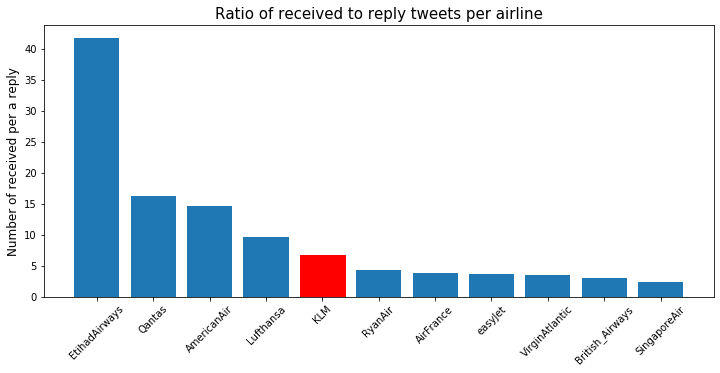

In [65]:
plt.figure(figsize=(12,5))
pl = plt.bar(reps_sort['airline'], reps_sort['rec_to_rep_ratio'])
plt.xticks(rotation='45')
plt.title('Ratio of received to reply tweets per airline', size=15)
plt.ylabel('Number of received per a reply', size=12)
pl[4].set_color('r')

In [52]:
print('SingaporeAir:', air_count['SingaporeAir']['rec_to_rep'], '\n', 'KLM:', air_count['KLM']['rec_to_rep'], '\n' 'Mean:', st.mean(list(reps['rec_to_rep_ratio'])))


SingaporeAir: 2.4514672686230248 
 KLM: 6.780810038767599 
Mean: 9.986088144227395


Overall number of received tweets from users 

In [58]:
rec_tweets = pd.DataFrame(columns=['airline', 'received'])
rec_tweets['airline'] = airlines.keys()
rec_tweets['received'] = [air_count[name]['received'] for name in air_count]
rec_tweets_sort = rec_tweets.sort_values(by='received', ascending=False)
rec_tweets_sort

,airline,received
3,AmericanAir,274058
2,British_Airways,200492
7,easyJet,133499
0,KLM,132931
10,Qantas,86902
4,Lufthansa,82001
12,VirginAtlantic,50536
8,RyanAir,39577
1,AirFrance,29773
9,SingaporeAir,20634


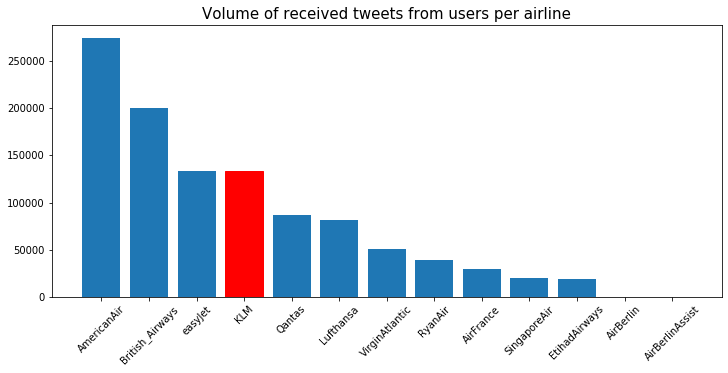

In [67]:
plt.figure(figsize=(12,5))
pl = plt.bar(rec_tweets_sort['airline'], rec_tweets_sort['received'])
plt.xticks(rotation='45')
plt.title('Volume of received tweets from users per airline', size=15)
pl[3].set_color('r');

In [53]:
rep_ratios = pd.DataFrame(columns=['airline', 'rep_to_all'])
rep_ratios['airline'] = [i for i in airlines.keys()]
rep_ratios['rep_to_all'] = [air_count[name]['rep_to_all'] for name in airlines.keys()]
rep_ratios_sort = rep_ratios.sort_values(by='rep_to_all', ascending=False)
rep_ratios_sort

,airline,rep_to_all
9,SingaporeAir,0.289732
2,British_Airways,0.247580
12,VirginAtlantic,0.222344
7,easyJet,0.211097
1,AirFrance,0.208481
8,RyanAir,0.187564
0,KLM,0.128521
4,Lufthansa,0.094522
3,AmericanAir,0.063738
10,Qantas,0.057922


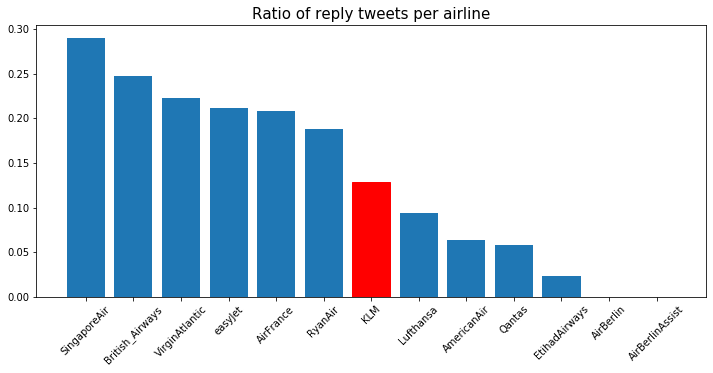

In [55]:
plt.figure(figsize=(12,5))
pl = plt.bar(rep_ratios_sort['airline'], rep_ratios_sort['rep_to_all'])
plt.xticks(rotation='45')
plt.title('Ratio of reply tweets per airline', size=15)
pl[6].set_color('r');

Replies over all tweets

In [39]:
print('KLM:', air_count['KLM']['rep_to_all'], '\n', 'Mean:',  st.mean(list(rep_ratios['rep_to_all'])))


KLM: 0.12852132297505492 
 Mean: 0.13345621304626304


Number of tweets received from users normalized on the number of followers -> THIS WON'T BE INCLUDED

In [40]:
for name in airlines:
    if name != 'AirBerlin' and name != 'AirBerlinAssist':
        air_count[name]['followers'] = col.find_one({'user.id': airlines[name]})['user']['followers_count']
        air_count[name]['norm_tweets'] = (air_count[name]['nr']*(1-air_count[name]['rep_ratio']))/air_count[name]['followers']
    else:
        air_count[name]['followers'] = 'unknown'
        air_count[name]['norm_tweets'] = 'unknown'

Note: AirBerlin and AirBerlinAssist are not included since we don't have any tweets from them, hence no information on the number of followers.

In [29]:
for name in airlines:
    print(air_count[name]['norm_tweets'])

0.05690315278679093
0.08737490829053558
0.16499212861505594
0.17534325455220157
0.19193193521205879
unknown
unknown
0.2859667462095734
0.09204724116437656
0.029041847058094955
0.18126486170789705
0.028696688242086328
0.08238347374735909


We get the ratio of tweets customers post to the number of followers a company has.
This is problematic since we are not sure the people who tweeted about an airline are actually their followers.

- Getting the number of conversations per airline (this is old version of conversations so Bornas numbers are actually used)

In [76]:
#this took some time
for name in airlines:
    if name not in 'AirBerlinAssist':
        print(name)
        air_count[name]['nr_conv'] = 0
        for i in convos:
            if int(i) in air_count[name]['ids']:
                air_count[name]['nr_conv'] += 1
    else: 
        air_count[name]['nr_conv'] = 'unknown'

KLM
AirFrance
British_Airways
AmericanAir
Lufthansa
easyJet
RyanAir
SingaporeAir
Qantas
EtihadAirways
VirginAtlantic


In [80]:
for name in airlines:
    print(air_count[name]['nr_conv'])

10849
3250
38841
23049
4898
unknown
unknown
20244
4877
3636
5948
1134
8532


In [87]:
pickle.dump(air_count, open( "save2.p", "wb" ))